# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

!pip install -U --pre tensorflow=="2.*"
#!pip install tf_slim

Make sure you have `pycocotools` installed

Get `tensorflow/models` or `cd` to parent directory of the repository.

Compile protobufs and install the object_detection package

### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import os
import pathlib
import imutils
import pandas as pd


from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [4]:
loaded_model = None

def load_model(model_dir):
    global loaded_model
    # load_model
    model = tf.saved_model.load(str(model_dir))
    return model

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/home/user/TensorFlow/workspace/training_AS/annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/home/user/TensorFlow/workspace/training_AS/images/test/')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))


# Detection

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def get_true_y(csv, img_error_lst):  
    true_y_col = csv["label_SIJ"].to_list()
    true_y = []
    
    filename_lst = sorted(list(set(csv["Filename"].to_list())))
    for i, file in enumerate(filename_lst):
        if file in img_error_lst:
            continue
        label = [true_y_col[2*i],true_y_col[2*i+1]]
        true_y += label
    true_y = np.array(true_y)
    true_y[true_y=="negative"] = 0
    true_y[true_y=="positive"] = 1
    true_y = list(map(int, true_y))
 #   print(true_y, len(true_y))
    return true_y

# get biggest prediction result
def get_pred_y(prediction_lst):
    pred_y = []
    score_dict = {}
    for output_dict in prediction_lst[:]:
        detection_scores = output_dict["detection_scores"]
        detection_classes = output_dict["detection_classes"]
    #    print(detection_classes[:6])
    #    print(detection_scores[:6])
        detection_boxes = output_dict["detection_boxes"] #ymin, xmin, ymax, xmax
        filename = output_dict["filename"]
        position = ["right" if i[1] > 0.5 else "left" for i in detection_boxes]
    #    print(position, position.index("right"), position.index("left"))
        pred_y += [detection_classes[position.index("right")],detection_classes[position.index("left")]]
        score_dict[filename] = (detection_scores[position.index("right")],detection_scores[position.index("left")])

  #  print(pred_y)
    return pred_y, score_dict

# classification results

def visualize_classification_result(true_y, pred_y):
    cm = confusion_matrix(true_y, pred_y, normalize='true')
    print(classification_report(true_y, pred_y))

    classes = [0,1]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, round(cm[i, j], 3),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Load an object detection model:

In [6]:
#model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
#model_dir = "/home/user/TensorFlow/workspace/training_AS/exported-models/my_model_200925/saved_model"
#detection_model = load_model(str(model_dir))


Check the model's input signature, it expects a batch of 3-color images of type uint8:

detection_model.signatures["serving_default"].inputs

And returns several outputs:

detection_model.signatures['serving_default'].output_dtypes

detection_model.signatures['serving_default'].output_shapes

detection_model.signatures['serving_default'].structured_outputs

In [7]:
csvpath = "/home/user/TensorFlow/workspace/training_AS/images/test/test.csv"
csv = pd.read_csv(csvpath)
csv = csv.sort_values(by=["Filename", "BX"])

Add a wrapper function to call the model, and cleanup the outputs:

In [8]:
def run_inference_for_single_image(model, image):
#    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                   for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
  
    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

Run it on each test image and show the results:

In [9]:
def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

    display(Image.fromarray(image_np))

my_model2


# error image count71
              precision    recall  f1-score   support

           0       0.33      0.96      0.50        78
           1       0.77      0.06      0.12       160

    accuracy                           0.36       238
   macro avg       0.55      0.51      0.31       238
weighted avg       0.63      0.36      0.24       238



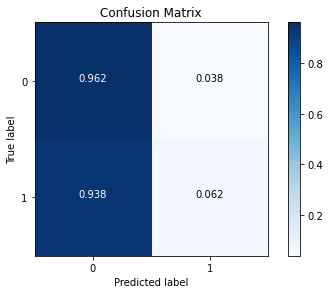

efficientdet_d4_coco17_tpu-32_12


# error image count71
              precision    recall  f1-score   support

           0       0.67      0.72      0.70        78
           1       0.86      0.83      0.84       160

    accuracy                           0.79       238
   macro avg       0.77      0.77      0.77       238
weighted avg       0.80      0.79      0.80       238



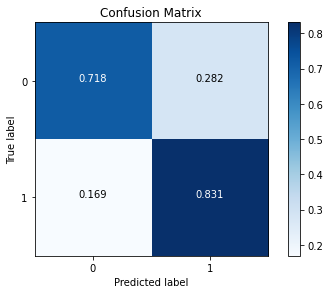

my_model_200925


# error image count71
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        78
           1       0.86      0.85      0.86       160

    accuracy                           0.81       238
   macro avg       0.78      0.78      0.78       238
weighted avg       0.81      0.81      0.81       238



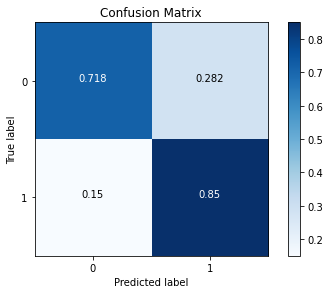

efficientdet_d4_coco17_tpu-32_13


# error image count71
              precision    recall  f1-score   support

           0       0.71      0.72      0.71        78
           1       0.86      0.86      0.86       160

    accuracy                           0.81       238
   macro avg       0.79      0.79      0.79       238
weighted avg       0.81      0.81      0.81       238



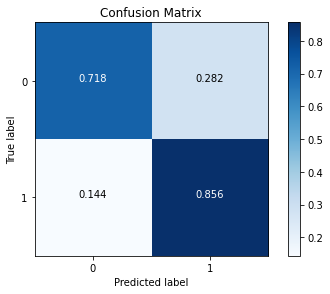

efficientdet_d4_coco17_tpu-32_10


# error image count71
              precision    recall  f1-score   support

           0       0.70      0.73      0.72        78
           1       0.87      0.85      0.86       160

    accuracy                           0.81       238
   macro avg       0.78      0.79      0.79       238
weighted avg       0.81      0.81      0.81       238



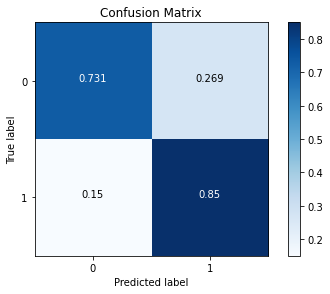

efficientdet_d4_coco17_tpu-32_9
efficientdet_d4_coco17_tpu-32_9
error
efficientdet_d4_coco17_tpu-32_5


# error image count71
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        78
           1       0.86      0.88      0.87       160

    accuracy                           0.82       238
   macro avg       0.80      0.79      0.79       238
weighted avg       0.82      0.82      0.82       238



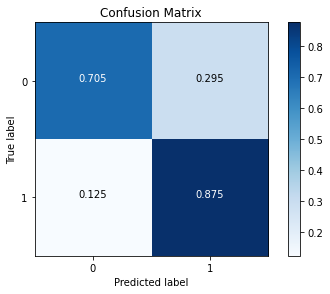

efficientdet_d3_coco17_tpu-32


# error image count71
              precision    recall  f1-score   support

           0       0.33      1.00      0.50        78
           1       1.00      0.03      0.06       160

    accuracy                           0.35       238
   macro avg       0.67      0.52      0.28       238
weighted avg       0.78      0.35      0.21       238



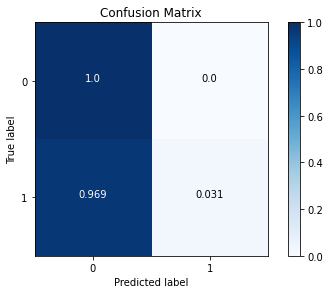

efficientdet_d4_coco17_tpu-32_3


# error image count71
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        78
           1       0.87      0.87      0.87       160

    accuracy                           0.82       238
   macro avg       0.80      0.80      0.80       238
weighted avg       0.82      0.82      0.82       238



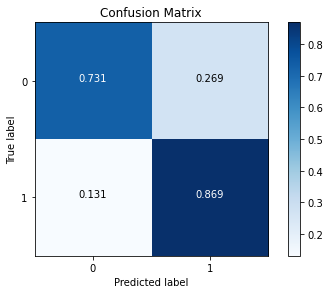

efficientdet_d4_coco17_tpu-32_2


# error image count71
              precision    recall  f1-score   support

           0       0.73      0.74      0.74        78
           1       0.87      0.87      0.87       160

    accuracy                           0.83       238
   macro avg       0.80      0.81      0.81       238
weighted avg       0.83      0.83      0.83       238



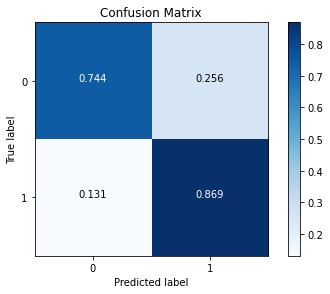

efficientdet_d4_coco17_tpu-32_14


# error image count71
              precision    recall  f1-score   support

           0       0.68      0.82      0.74        78
           1       0.90      0.81      0.86       160

    accuracy                           0.82       238
   macro avg       0.79      0.82      0.80       238
weighted avg       0.83      0.82      0.82       238



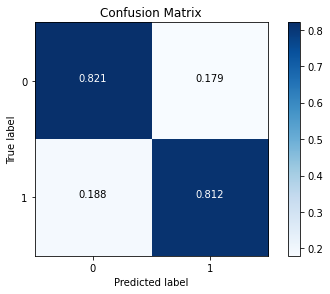

my_model


# error image count71
              precision    recall  f1-score   support

           0       0.33      1.00      0.50        78
           1       1.00      0.03      0.06       160

    accuracy                           0.35       238
   macro avg       0.67      0.52      0.28       238
weighted avg       0.78      0.35      0.21       238



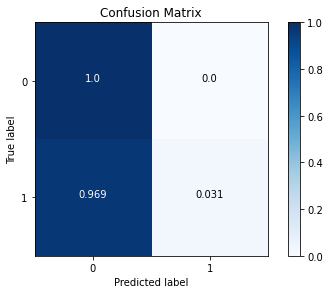

random_state
random_state
error
efficientdet_d4_coco17_tpu-32
efficientdet_d4_coco17_tpu-32
error
efficientdet_d4_coco17_tpu-32_4


# error image count71
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        78
           1       0.87      0.86      0.86       160

    accuracy                           0.82       238
   macro avg       0.79      0.79      0.79       238
weighted avg       0.82      0.82      0.82       238



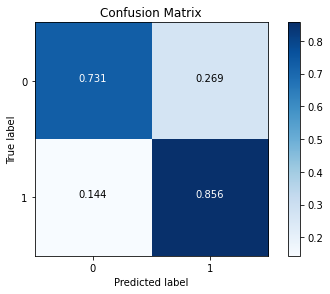

efficientdet_d4_coco17_tpu-32_1


# error image count71
              precision    recall  f1-score   support

           0       0.70      0.71      0.70        78
           1       0.86      0.85      0.85       160

    accuracy                           0.80       238
   macro avg       0.78      0.78      0.78       238
weighted avg       0.80      0.80      0.80       238



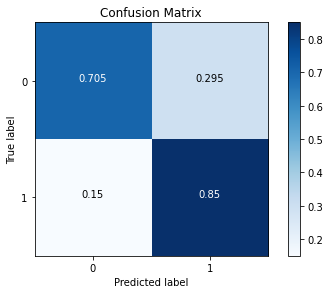

efficientdet_d4_coco17_tpu-32_11


# error image count71
              precision    recall  f1-score   support

           0       0.70      0.73      0.71        78
           1       0.87      0.84      0.85       160

    accuracy                           0.81       238
   macro avg       0.78      0.79      0.78       238
weighted avg       0.81      0.81      0.81       238



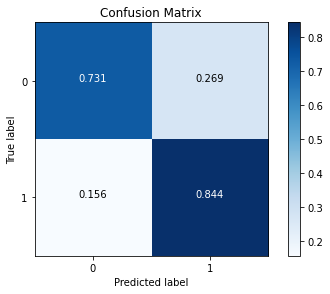

efficientdet_d4_coco17_tpu-32_6


# error image count71
              precision    recall  f1-score   support

           0       0.72      0.71      0.71        78
           1       0.86      0.87      0.86       160

    accuracy                           0.82       238
   macro avg       0.79      0.79      0.79       238
weighted avg       0.81      0.82      0.81       238



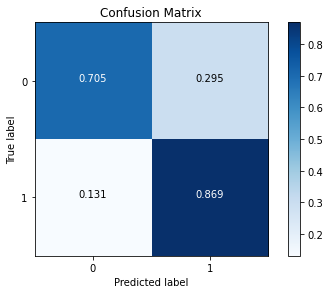

efficientdet_d4_coco17_tpu-32_7


# error image count71
              precision    recall  f1-score   support

           0       0.71      0.72      0.71        78
           1       0.86      0.86      0.86       160

    accuracy                           0.81       238
   macro avg       0.79      0.79      0.79       238
weighted avg       0.81      0.81      0.81       238



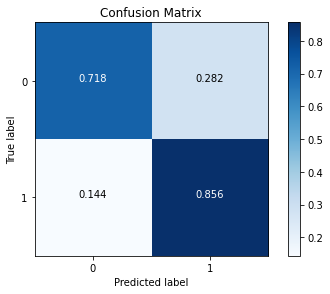

In [10]:
import warnings
warnings.filterwarnings('ignore')

base_path = "/home/user/TensorFlow/workspace/training_AS/exported-models"
prediction_lst = []
error_imgs = []
count = 0

for folder in os.listdir(base_path)[1:]:
    prediction_lst = []
    error_imgs = []
    print(folder)
    model_dir = os.path.join(base_path, folder, "saved_model")
#    model_dir = "/home/user/TensorFlow/workspace/training_AS/exported-models/my_model_200925/saved_model"
    try:
        detection_model = load_model(str(model_dir))
    except:
        print(folder)
        print("error")
        continue
    
    count = 0
    for image_path in TEST_IMAGE_PATHS:
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = np.array(Image.open(image_path))
        image_np = imutils.resize(image_np, width=1024)
        # Actual detection.
        try:
    #        print(image_path)
            output_dict = run_inference_for_single_image(detection_model, image_np)
    #        print(output_dict['detection_scores'][:3], output_dict['detection_classes'][:3])
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks_reframed', None),
              use_normalized_coordinates=True,
              min_score_thresh=0.7,
              line_thickness=8)
            output_dict["filename"] = image_path
            prediction_lst.append(output_dict)
 #           display(Image.fromarray(image_np))
        except Exception as ex:
            count += 1
            error_imgs.append(image_path)
  #          print(image_path)
  #          print(ex)
    print("# error image count" + str(count))
    
    img_error_lst = [error_img.name for error_img in error_imgs]

    true_y = get_true_y(csv, img_error_lst)
    pred_y, score_dict = get_pred_y(prediction_lst)
    visualize_classification_result(true_y, list(np.array(pred_y)-1))


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
#visualize_classification_result(true_y, pred_y)
len(true_y)
len(pred_y)

238